In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
# from spikingjelly.clock_driven import functional, surrogate, neuron, layer
from spikingjelly.activation_based import spike_op as sn
from spikingjelly.activation_based import functional, surrogate, neuron, layer, encoding
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
import time
import torchmetrics
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torchinfo import summary
np.int = int
save_dir = './model_checkpoints'
os.makedirs(save_dir, exist_ok=True)

c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:84: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias, stride, padding, dilation, groups):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:110: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\spikingjelly\activation_based\spike_op.py:152: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, spike, weight, bias=None):
c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\s

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class FERPlusDataset(Dataset):
    def __init__(self, image_folder, label_csv, transform=None, use_soft_labels=True):
        self.image_folder = image_folder
        self.labels = pd.read_csv(label_csv, header=None)

        # Update column names to match CSV structure
        self.transform = transform
        self.labels.columns = [
            "filename", "roi",
            "neutral", "happiness", "surprise",
            "sadness", "anger", "disgust",
            "fear", "contempt", "unknown", "NF"
        ]

        self.use_soft_labels = use_soft_labels
        self.labels.drop(columns=["roi", "unknown", "NF"], inplace=True)
        label_columns = ["neutral", "happiness", "surprise",
                         "sadness", "anger", "disgust", "fear", "contempt"]
        self.labels = self.labels[self.labels[label_columns].sum(
            axis=1) > 0].reset_index(drop=True)
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Get image filename and full path
        filename = self.labels.iloc[idx]["filename"]
        img_path = os.path.join(self.image_folder, filename)

        # Load and transform the image
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        label = self.labels.iloc[idx, 1:].values.astype(float)

        if self.use_soft_labels:
            # Soft labels: return the label as is
            label = torch.tensor(label, dtype=torch.float32)
        else:
            # Hard labels: return the class index (max index of the one-hot vector)
            label = torch.tensor(label.argmax(), dtype=torch.long)
        return image, label

In [3]:
# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),  # Resize to 48x48 (FER image size)
    transforms.ToTensor(),       # Convert to tensor
])

In [4]:
time_steps = 4
batch_size = 16
learning_rate = 1e-3
epochs = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
use_soft_labels = True
num_classes = 8
use_image_folder = True
if use_image_folder:
  use_soft_labels = False
  num_classes = 7

In [5]:
from collections import Counter
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

# Paths
train_folder = "./dataset/data/d/FER2013Train" if not use_image_folder else "./dataset/train"
train_labels = "./dataset/data/d/FER2013Train/label.csv"
valid_folder = "./dataset/data/d/FER2013Valid"
valid_labels = "./dataset/data/d/FER2013Valid/label.csv"
test_folder = "./dataset/data/d/FER2013Test" if not use_image_folder else "./dataset/test"
test_labels = "./dataset/data/d/FER2013Test/label.csv"

# Load datasets
if  not use_image_folder:
    train_dataset = FERPlusDataset(
        image_folder=train_folder, label_csv=train_labels, transform=transform, use_soft_labels=use_soft_labels)
    valid_dataset = FERPlusDataset(image_folder=valid_folder, label_csv=valid_labels, transform=transform,use_soft_labels=use_soft_labels)
    test_dataset = FERPlusDataset(image_folder=test_folder, label_csv=test_labels,
                                transform=transform, use_soft_labels=use_soft_labels)
else:
    train_dataset = datasets.ImageFolder(train_folder, transform=transform)
    test_dataset = datasets.ImageFolder(test_folder, transform=transform)

def get_labels(dataset):
    all_labels = []
    for _, label in dataset:
        if use_soft_labels:
            all_labels.append(label.argmax().item())
        else:
            all_labels.append(label.item() if not use_image_folder else label)  # For hard labels
    count = Counter(all_labels)
    print(count)
    sample_count = np.array([count[i] for i in range(num_classes)])
    weight = 1. / sample_count
    samples_weight = np.array([weight[t] for t in all_labels])
    samples_weight = torch.from_numpy(samples_weight)
    return samples_weight, all_labels
# Extract all labels from the training dataset
train_weight, train_labels = get_labels(train_dataset)
test_weight, test_labels = get_labels(test_dataset)

# Compute class weights
class_weights_tain = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights_test = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(test_labels),
    y=test_labels
)
# print()
# Convert class weights to a tensor
class_weights_train_tensor = torch.tensor(class_weights_tain, dtype=torch.float32).to(device)
class_weights_test_tensor = torch.tensor(class_weights_test, dtype=torch.float32).to(device)


train_sampler = WeightedRandomSampler(train_weight, len(train_weight), replacement=True)
test_sampler = WeightedRandomSampler(test_weight, len(test_weight), replacement=True)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler,
                          shuffle=False, drop_last=True)
if not use_image_folder:
    # val_weight, val_labels = get_labels(valid_dataset)
    # valid_sampler = WeightedRandomSampler(val_weight, len(val_weight), replacement=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16,
                          shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16,sampler=test_sampler,
                          shuffle=False, drop_last=True)

Counter({3: 7215, 4: 4965, 5: 4830, 2: 4097, 0: 3995, 6: 3171, 1: 436})
Counter({3: 1774, 5: 1247, 4: 1233, 2: 1024, 0: 958, 6: 831, 1: 111})


In [6]:

class CSNN(nn.Module):
    def __init__(self,out_class=7, T=8):
        super(CSNN, self).__init__()
        self.T = T
        self.out_class = out_class
        self.layer1 = nn.Sequential(
            layer.Conv2d(1, 128, kernel_size=3, stride=1,
                         padding=1, step_mode='s'),
            layer.BatchNorm2d(128, step_mode='s'),
        )
        self.layer2 = nn.Sequential(
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2, stride=2),
            layer.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            layer.BatchNorm2d(128),
            neuron.IFNode(v_threshold=1.0,
                          surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.MaxPool2d(kernel_size=2)
        )
        self.layer3 = nn.Sequential(
            layer.Flatten(),
            layer.Dropout(p=0.5),
            layer.Linear(128*12*12, 1152),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Dropout(p=0.5),
            layer.Linear(1152, 128),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m'),
            layer.Linear(128, self.out_class),
            neuron.LIFNode(tau=2.0, v_reset=0.0,
                           surrogate_function=surrogate.ATan(), step_mode='m')
        )

        functional.set_step_mode(self.layer2, step_mode='m')
        functional.set_step_mode(self.layer3, step_mode='m')
        functional.set_backend(self, backend='torch')
        self.pe = encoding.PoissonEncoder()

    def forward(self, x):
        # x = self.pe(x)
        x = self.layer1(x)
        x_step = x.unsqueeze(0).repeat(self.T, 1, 1, 1, 1)
        out1 = self.layer2(x_step)
        out2 = self.layer3(out1)
        return out2.mean(dim=0)

In [7]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.best_acc = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, model, val_loss, val_acc):
        if self.best_acc is None or val_acc > self.best_acc:
            self.best_acc = val_acc
            self.save_best(model)
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_best(model, is_loss=True)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_state(self, loss, acc, counter, early_stop):
        self.best_loss = loss
        self.best_acc = acc
        self.counter = counter
        self.early_stop = early_stop

    def get_state(self):
        return self.best_loss, self.best_acc, self.counter, self.early_stop

    def save_best(self, model, is_loss=False):
        torch.save(model.state_dict(), os.path.join(
            save_dir, f"best_model_{'acc' if is_loss else 'loss'}.pth"))


early_stopping = EarlyStopping(patience=10)

In [8]:
def smooth_one_hot(true_labels: torch.Tensor, classes: int, smoothing=0):
    """
    if smoothing == 0, it's one-hot method
    if 0 < smoothing < 1, it's smooth method

    """
    device = true_labels.device
    true_labels = torch.nn.functional.one_hot(
        true_labels, classes).detach().cuda()
    assert 0 <= smoothing < 1
    confidence = 1.0 - smoothing
    label_shape = torch.Size((true_labels.size(0), classes))
    with torch.no_grad():
        true_dist = torch.empty(
            size=label_shape, device=true_labels.device)
        true_dist.fill_(smoothing / (classes - 1))
        _, index = torch.max(true_labels, 1)

        index = torch.tensor(index.unsqueeze(
            1).clone().detach(), dtype=torch.int64, device=device)
        true_dist.scatter_(1, index, confidence).to(device)
    return true_dist.to(device)


def train(model, loader, optimizer, criterion, use_soft_labels=False):
    if use_soft_labels or use_image_folder:
        # criterion = nn.BCEWithLogitsLoss().to(device)
        criterion = nn.MSELoss().to(device)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.5).to(device)
    model.train()
    total_loss, correct = 0, 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if use_soft_labels or use_image_folder:
        #   target_onehot = torch.nn.functional.one_hot(
        #       target, num_classes=7).float()
          target_onehot = smooth_one_hot(target, classes=num_classes, smoothing=0)
          loss = criterion(output, target_onehot)
        else:
          loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
        correct += (output.argmax(dim=1) == target).sum().item()
        # correct += (output.argmax(dim=1) == target.argmax(dim=1) if use_soft_labels else target).sum().item()
        functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def validate(model, loader, criterion, use_soft_labels=False):
    if use_soft_labels or use_image_folder:
        # criterion = nn.BCEWithLogitsLoss().to(device)
        criterion = nn.MSELoss().to(device)
    else:
        criterion = nn.CrossEntropyLoss(label_smoothing=0.5).to(device)
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if use_soft_labels or use_image_folder:
              target_onehot = smooth_one_hot(target, classes=num_classes, smoothing=0)
            #   target_onehot = target
            #   target_onehot = torch.nn.functional.one_hot(target, num_classes=7).float().detach().cuda()
              loss = criterion(output, target_onehot)
            else:
              loss = criterion(output, target)
            total_loss += loss.item() * data.size(0)
            correct += (output.argmax(dim=1)==target).sum().item()
            # correct += (output.argmax(dim=1) == target.argmax(dim=1) if use_soft_labels else target).sum().item()
            functional.reset_net(model)  # Reset neuron states
    return total_loss / len(loader.dataset), correct / len(loader.dataset)


def save_checkpoint(model, optimizer, lr_scheduler, early_stopping, epoch, path="./model_checkpoints/csnn_checkpoint.pth"):
    best_loss, best_acc, counter, early_stop = early_stopping.get_state()
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'best_loss': best_loss,
        'best_acc': best_acc,
        'counter': counter,
        'early_stop': early_stop,
        'lr_scheduler_dict': lr_scheduler.state_dict()
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at epoch {epoch}")


def load_checkpoint(model, optimizer, lr_scheduler, early_stopping, path="./model_checkpoints/csnn_checkpoint.pth"):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    lr_scheduler.load_state_dict(checkpoint['lr_scheduler_dict'])
    epoch = checkpoint['epoch']
    early_stopping.load_state(
        checkpoint['best_loss'], checkpoint['best_acc'], checkpoint['counter'], checkpoint['early_stop'])
    print(f"Checkpoint loaded, resuming from epoch {epoch}")
    return epoch

In [9]:


train_acc_hist = []
val_acc_hist = []
train_loss_hist = []
val_loss_hist = []


def train_model(model, resume=False):
    criterion = None
    # if use_soft_labels:
    #     # criterion = nn.BCEWithLogitsLoss().to(device)
    #     criterion = nn.MSELoss().to(device)
    # else:
    #     criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    # Track training time
    start_time = time.time()
    # Train and Validate
    start_epoch = 1
    if resume:
        start_epoch = load_checkpoint(model, optimizer, lr_scheduler, early_stopping)
    for epoch in range(start_epoch, epochs + 1):
        train_loss, train_acc = train(
            model, train_loader, optimizer, criterion, use_soft_labels)
        val_loss, val_acc = validate(model, test_loader, criterion, use_soft_labels)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {100*train_acc:.4f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {100*val_acc:.4f}%")

        early_stopping(model, val_loss, val_acc)
        save_checkpoint(model, optimizer, lr_scheduler, early_stopping, epoch + 1)
        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break
        lr_scheduler.step(val_loss)
        if epoch % 30 == 0:
            break

    # Training time
    training_time = time.time() - start_time
    print(f"Training Time: {training_time / 60:.2f} minutes")

In [10]:
from torchinfo import summary
model = CSNN(T=time_steps, out_class=num_classes).to(device)
# summary(model, (batch_size, 1, 48, 48), col_names=["input_size", "output_size","num_params"])

In [14]:
train_model(model, resume=True)
# model_data = {
#   "tloss": train_loss_hist,
#   "tacc": train_acc_hist,
#   "vloss": val_loss_hist,
#   "vacc": val_acc_hist
# }
# torch.save(model_data, './model_checkpoints/loss_acc_data.pth')

c:\Users\SHAURYAM DUBEY\Documents\.repo-github\csnn\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
C:\Users\SHAURYAM DUBEY\AppData\Local\Temp\ipykernel_3360\1964669466.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting 

Checkpoint loaded, resuming from epoch 31


C:\Users\SHAURYAM DUBEY\AppData\Local\Temp\ipykernel_3360\1964669466.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(index.unsqueeze(


Epoch 31: Train Loss: 0.0202, Train Acc: 91.3093%, Val Loss: 0.0936, Val Acc: 56.6592%
Checkpoint saved at epoch 32
Epoch 32: Train Loss: 0.0196, Train Acc: 91.8249%, Val Loss: 0.0924, Val Acc: 56.7986%
Checkpoint saved at epoch 33
Epoch 33: Train Loss: 0.0193, Train Acc: 91.9119%, Val Loss: 0.0909, Val Acc: 58.3449%
Checkpoint saved at epoch 34
Epoch 34: Train Loss: 0.0183, Train Acc: 92.5145%, Val Loss: 0.0934, Val Acc: 57.3976%
Checkpoint saved at epoch 35
Epoch 35: Train Loss: 0.0177, Train Acc: 92.7619%, Val Loss: 0.0955, Val Acc: 56.2970%
Checkpoint saved at epoch 36
Epoch 36: Train Loss: 0.0174, Train Acc: 92.7479%, Val Loss: 0.0943, Val Acc: 56.1716%
Checkpoint saved at epoch 37
Epoch 37: Train Loss: 0.0169, Train Acc: 93.1171%, Val Loss: 0.0937, Val Acc: 57.2026%
Checkpoint saved at epoch 38
Epoch 38: Train Loss: 0.0164, Train Acc: 93.3087%, Val Loss: 0.0936, Val Acc: 56.7150%
Checkpoint saved at epoch 39


KeyboardInterrupt: 

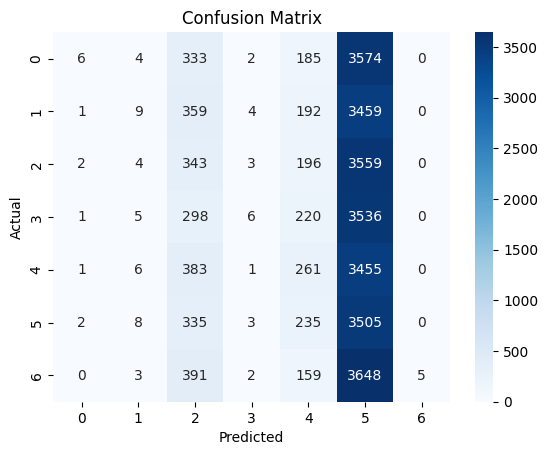

              precision    recall  f1-score   support

           0       0.46      0.00      0.00      4104
           1       0.23      0.00      0.00      4024
           2       0.14      0.08      0.10      4107
           3       0.29      0.00      0.00      4066
           4       0.18      0.06      0.09      4107
           5       0.14      0.86      0.24      4088
           6       1.00      0.00      0.00      4208

    accuracy                           0.14     28704
   macro avg       0.35      0.14      0.06     28704
weighted avg       0.35      0.14      0.06     28704



In [15]:
# Post-training metrics and analysis
# model.load_state_dict(torch.load('sjcnn_final.pth', map_location=device))
# model.load_state_dict(torch.load(os.path.join(save_dir, 'best_model_loss.pth')))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # print(output)
        # print(target)
        # break
        y_true.extend((target.argmax(dim=1) if use_soft_labels else target).cpu().numpy())
        y_pred.extend(output.argmax(dim=1).cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred))